In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

# Carregando dados

In [5]:
# Carregar os dados
df = pd.read_csv('data_yfinance/stocks.csv')

# Filtrar as datas de interesse (2017-02-24 até hoje)
start_date = '2019-01-01'
df['Date'] = pd.to_datetime(df['Date'])
filtered_df = df[df['Date'] >= start_date]

# Removendo ".SA"

In [7]:
filtered_df['ticker'] = filtered_df['ticker'].apply(lambda x: x[:-3])
filtered_df

C:\Users\Matheus Poletto\AppData\Local\Temp\ipykernel_16580\2309112757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['ticker'] = filtered_df['ticker'].apply(lambda x: x[:-3])


,Date,Open,High,Low,Close,ticker
462,2019-01-02,22.549999,24.200001,22.280001,24.059999,PETR4
463,2019-01-03,23.959999,24.820000,23.799999,24.650000,PETR4
464,2019-01-04,24.850000,24.940001,24.469999,24.719999,PETR4
465,2019-01-07,24.850000,25.920000,24.700001,25.110001,PETR4
466,2019-01-08,25.400000,25.420000,24.770000,24.959999,PETR4
...,...,...,...,...,...,...
730056,2024-07-03,3.720000,3.800000,3.700000,3.740000,ZAMP3
730057,2024-07-04,3.850000,3.900000,3.840000,3.870000,ZAMP3
730058,2024-07-05,3.870000,3.930000,3.810000,3.910000,ZAMP3
730059,2024-07-08,3.660000,3.730000,3.530000,3.570000,ZAMP3


# Cálculo estatísticas

In [8]:
# Calcular as estatísticas relevantes
def calculate_ticker_stats(df):
    # Calcular retornos diários
    df['Return'] = df.groupby('ticker')['Close'].pct_change()

    # Definindo uma taxa livre de risco anual
    annual_risk_free_rate = 0.0729  # 7,29% foi a média anual aproximada de 100% do CDI nos últimos 7 anos

    # Calcular o número de anos nos dados para anualizar os retornos diários
    num_years = (df['Date'].max() - df['Date'].min()).days / 365.25

    # Agrupando por 'ticker' e calculando as métricas necessárias
    ticker_stats = df.groupby('ticker').agg(
        avg_return=('Return', lambda x: (1 + x).prod() ** (1 / num_years) - 1),  # retorno médio anualizado
        volatility=('Return', 'std'),  # desvio padrão dos retornos
        cumulative_return=('Return', lambda x: (1 + x).prod() - 1),  # retorno acumulado
        sharpe_ratio=('Return', lambda x: ((x.mean() * 252 - annual_risk_free_rate) /
                                           (x.std() * (252 ** 0.5))) if x.std() != 0 else None)
        # Sharpe ratio anualizado, considerando 252 dias de negociação por ano
    ).reset_index()

    return ticker_stats

In [9]:
def calculate_rvi(avg_return, volatility, sharpe_ratio, alpha, beta, gamma):
    return alpha * avg_return + beta * volatility + gamma * sharpe_ratio


# Pesos para o modelo de decisão
weights = {
    'Conservador': {'alpha': 0.1, 'beta': 0.8, 'gamma': 0.1},
    'Moderado': {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.8},
    'Arrojado': {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.1}
}

def apply_profiles(ticker_stats, weights):
    rvi_scores = {}
    for profile, params in weights.items():
        rvi_scores[profile] = ticker_stats.apply(
            lambda row: calculate_rvi(row['avg_return'], row['volatility'], row['sharpe_ratio'], 
                                      params['alpha'], params['beta'], params['gamma']),
            axis=1
        )
    return rvi_scores

# Calcular as estatísticas dos tickers
ticker_stats = calculate_ticker_stats(filtered_df)

# Aplicar os perfis de investimento
rvi_scores = apply_profiles(ticker_stats, weights)

# Adicionar os scores ao dataframe de estatísticas dos tickers
for profile, score in rvi_scores.items():
    ticker_stats[f'rvi_{profile}'] = score

C:\Users\Matheus Poletto\AppData\Local\Temp\ipykernel_16580\2540944230.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'] = df.groupby('ticker')['Close'].pct_change()


# Resultado

## Resultado ordenado por avg_return

In [18]:
df = ticker_stats.sort_values(by='avg_return', ascending=False)
df

,ticker,avg_return,volatility,cumulative_return,sharpe_ratio,rvi_Conservador,rvi_Moderado,rvi_Arrojado
334,PRIO3,0.750106,0.038939,20.924489,1.115520,0.217714,0.971321,0.715530
152,DEXP3,0.667786,0.041679,15.807246,1.003182,0.200440,0.873492,0.638715
303,NUTR3,0.662826,0.061673,15.533333,0.857997,0.201420,0.758847,0.622228
364,RSUL4,0.549813,0.028475,10.213133,1.041658,0.181927,0.891155,0.546864
56,BMEB4,0.463225,0.023554,7.165517,1.023206,0.167487,0.867243,0.475256
...,...,...,...,...,...,...,...,...
243,JFEN3,-0.502644,0.066943,-0.978788,-0.269390,-0.023649,-0.259082,-0.422360
375,SEQL3,-0.511318,0.060054,-0.980750,-0.787596,-0.081849,-0.675203,-0.481809
21,AMER3,-0.525416,0.053977,-0.983621,-0.442748,-0.053635,-0.401343,-0.459210
298,NEXP3,-0.533770,0.048377,-0.985149,-0.721390,-0.086815,-0.625651,-0.494317


## Resultado com aplicação de coloração

In [71]:
df_rvi = pd.DataFrame(ticker_stats)

# Função para aplicar coloração condicional
def color_negative_red(value):
    color = 'red' if value < 0 else 'black'
    return f'color: {color}'

# Aplicar coloração condicional a todas as colunas exceto 'ticker' e 'volatility'
styled_df = df_rvi.style.applymap(color_negative_red, subset=pd.IndexSlice[:, ['avg_return', 'cumulative_return', 'sharpe_ratio', 'rvi_Conservador', 'rvi_Moderado', 'rvi_Arrojado']])

# Aplicar um gradiente de cor para a coluna 'volatility'
styled_df = styled_df.background_gradient(subset=['volatility'], cmap='Reds')

# Aplicar gradiente verde para valores positivos
def background_gradient(s, m, M, cmap='Greens', low=0, high=0):
    rng = M - m
    norm = mcolors.Normalize(m - (rng * low), M + (rng * high))
    normed = norm(s.values)
    c = [plt.get_cmap(cmap)(x) for x in normed]
    return ['background-color: %s' % mcolors.rgb2hex(rgb[:3]) for rgb in c]

# Aplicar gradiente verde às colunas especificadas
columns_to_gradient = ['avg_return', 'cumulative_return', 'sharpe_ratio', 'rvi_Conservador', 'rvi_Moderado', 'rvi_Arrojado']
for column in columns_to_gradient:
    styled_df = styled_df.apply(background_gradient, subset=[column], cmap='Greens', m=df_rvi[column].min(), M=df_rvi[column].max())

# Mostrar a tabela estilizada
styled_df

C:\Users\Matheus Poletto\AppData\Local\Temp\ipykernel_24208\3579681204.py:9: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df_rvi.style.applymap(color_negative_red, subset=pd.IndexSlice[:, ['avg_return', 'cumulative_return', 'sharpe_ratio', 'rvi_Conservador', 'rvi_Moderado', 'rvi_Arrojado']])


,ticker,avg_return,volatility,cumulative_return,sharpe_ratio,rvi_Conservador,rvi_Moderado,rvi_Arrojado
0,AALR3,-0.025412,0.033155,-0.132075,0.077570,0.031740,0.062830,-0.009257
1,ABCB4,0.052698,0.021345,0.326601,0.108547,0.033201,0.094242,0.055148
2,ABEV3,-0.060585,0.019006,-0.291022,-0.300059,-0.020860,-0.244205,-0.076573
3,ADHM3,0.040334,0.043395,0.243091,0.235128,0.062263,0.196475,0.060119
4,AERI3,-0.425088,0.040562,-0.952459,-1.110425,-0.121101,-0.926792,-0.447056
5,AESB3,-0.064670,0.016868,-0.307821,-0.564480,-0.049420,-0.456364,-0.106497
6,AFLT3,0.058406,0.071604,0.366667,0.347390,0.097863,0.290913,0.088624
7,AGRO3,0.100819,0.020753,0.696552,0.240783,0.050763,0.204783,0.106809
8,AGXY3,-0.286897,0.039060,-0.844444,-0.846834,-0.082125,-0.702251,-0.310295
9,AHEB3,-0.128547,0.039559,-0.531016,-0.013898,0.017403,-0.020017,-0.100271


# Exportação dos dados

In [15]:
if not os.path.exists('data_yfinance'):
    os.makedirs('data_yfinance')
    
df.to_csv("data_yfinance\stocks_rvi.csv", index=False)

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Matheus Poletto\AppData\Local\Temp\ipykernel_16580\3969375466.py:4: SyntaxWarning: invalid escape sequence '\s'
  df.to_csv("data_yfinance\stocks_rvi.csv", index=False)


# Criação de visuais

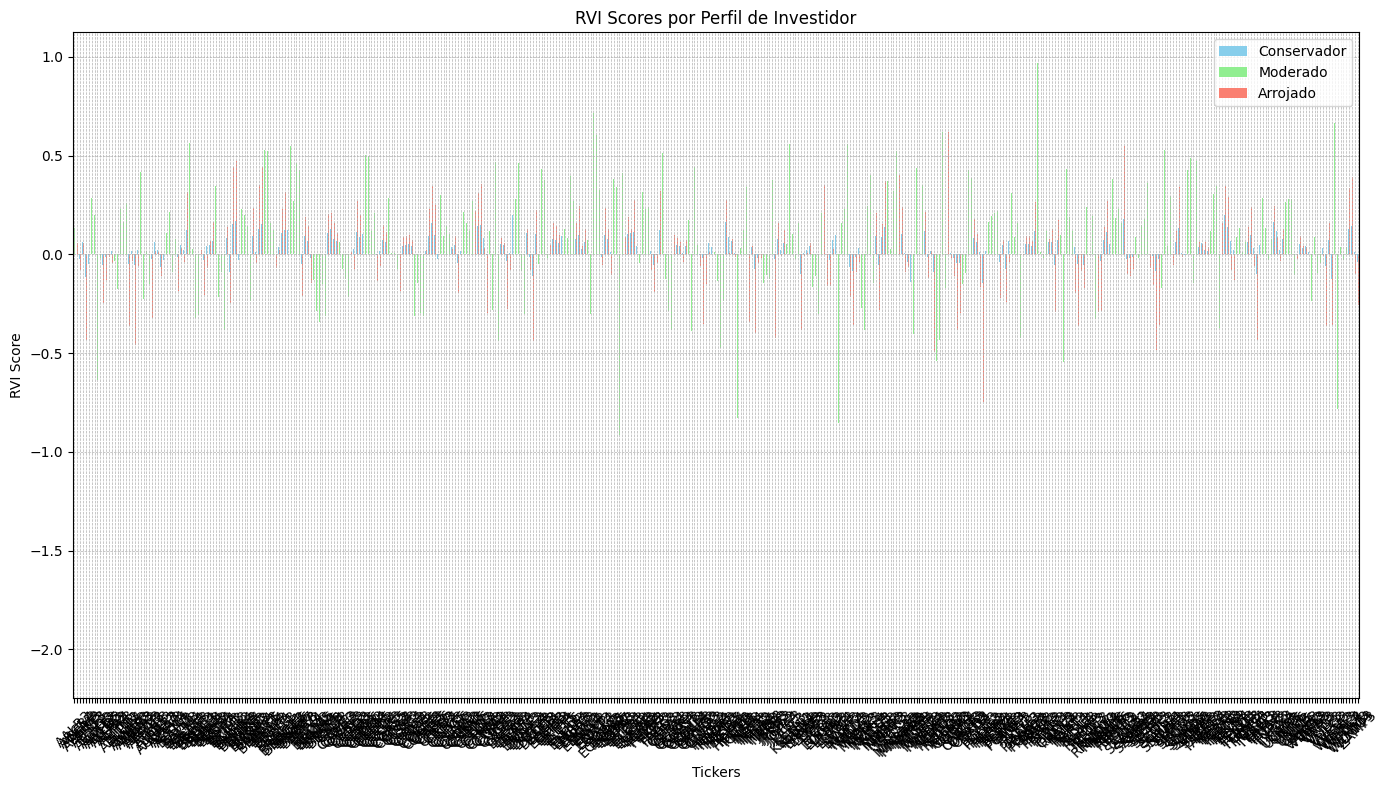

In [16]:
# Função para plotar um gráfico de barras colorido com grid
def plot_colorful_bars_with_grid(ticker_stats):
    profiles = ['rvi_Conservador', 'rvi_Moderado', 'rvi_Arrojado']
    colors = ['skyblue', 'lightgreen', 'salmon']
    ticker_stats.set_index('ticker')[profiles].plot(kind='bar', color=colors, figsize=(14, 8))
    plt.title('RVI Scores por Perfil de Investidor')
    plt.xlabel('Tickers')
    plt.ylabel('RVI Score')
    plt.legend(['Conservador', 'Moderado', 'Arrojado'])
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Plotar o gráfico colorido com grid
plot_colorful_bars_with_grid(ticker_stats)

In [17]:
# Visualizar as 5 primeiras ações únicas no dataframe
top_tickers = df['ticker'].unique()[:5]

# Filtrar o dataframe para incluir apenas as 5 ações
filtered_df = df[df['ticker'].isin(top_tickers)]

# Normalizar os preços de fechamento para cada ação
normalized_df = filtered_df.copy()
for ticker in top_tickers:
    initial_value = normalized_df[normalized_df['ticker'] == ticker]['Close'].iloc[0]
    normalized_df.loc[normalized_df['ticker'] == ticker, 'Normalized_Close'] = 100 * (normalized_df[normalized_df['ticker'] == ticker]['Close'] / initial_value - 1)

# Plotar as séries temporais normalizadas para cada ticker
plt.figure(figsize=(14, 8))
for ticker in top_tickers:
    plt.plot(normalized_df[normalized_df['ticker'] == ticker]['Date'], normalized_df[normalized_df['ticker'] == ticker]['Normalized_Close'], label=ticker)

plt.title('Preço de Fechamento Normalizado das Ações - Série Temporal (Porcentagem)')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento Normalizado (%)')
plt.legend(title='Ações')
plt.grid(True)
plt.show()

KeyError: 'Close'